
- Link dataset: https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists
- Dự đoán một ứng cử viên sẽ làm việc cho công ty hay không dựa vào các thuộc tính giới tính, kinh nghiệm, học vấn



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm

In [13]:
df=pd.read_csv('aug_train.csv', usecols=['gender','education_level','experience','target'])
df.head()


,gender,education_level,experience,target
0,Male,Graduate,>20,1.0
1,Male,Graduate,15,0.0
2,NaN,Graduate,5,0.0
3,NaN,Graduate,<1,1.0
4,Male,Masters,>20,0.0


# Xử lý dữ liệu trống

In [14]:
df.isnull().sum()


gender             4508
education_level     460
experience           65
target                0
dtype: int64

In [15]:
#     
# Gender
gender_random = df['gender'].dropna().sample(n=df['gender'].isnull().sum(),random_state=0)
gender_random.index = df[df['gender'].isnull()].index
df['gender_random']=df['gender']
df.loc[df['gender'].isnull(), 'gender_random']=gender_random

#Education level
education_level_random = df['education_level'].dropna().sample(n=df['education_level'].isnull().sum(),random_state=0)
education_level_random.index = df[df['education_level'].isnull()].index
df['education_level_random']=df['education_level']
df.loc[df['education_level'].isnull(), 'education_level_random']=education_level_random

#experience
experience_random = df['experience'].dropna().sample(n=df['experience'].isnull().sum(),random_state=0)
experience_random.index = df[df['experience'].isnull()].index
df['experience_random']=df['experience']
df.loc[df['experience'].isnull(), 'experience_random']=experience_random

df.head()




,gender,education_level,experience,target,gender_random,education_level_random,experience_random
0,Male,Graduate,>20,1.0,Male,Graduate,>20
1,Male,Graduate,15,0.0,Male,Graduate,15
2,NaN,Graduate,5,0.0,Male,Graduate,5
3,NaN,Graduate,<1,1.0,Male,Graduate,<1
4,Male,Masters,>20,0.0,Male,Masters,>20


# Mã hóa dữ liệu
Thay thế các giá trị:
# Gender 
- Male: 1
- Female: 0
- Other : 3
# Education level

- Primary School: 0
- High School: 1
- Graduate: 2
- Masters : 3
- Phd: 4
# Experience 
-+ >20 -> 21
- <1 : 0




<function matplotlib.pyplot.show(close=None, block=None)>

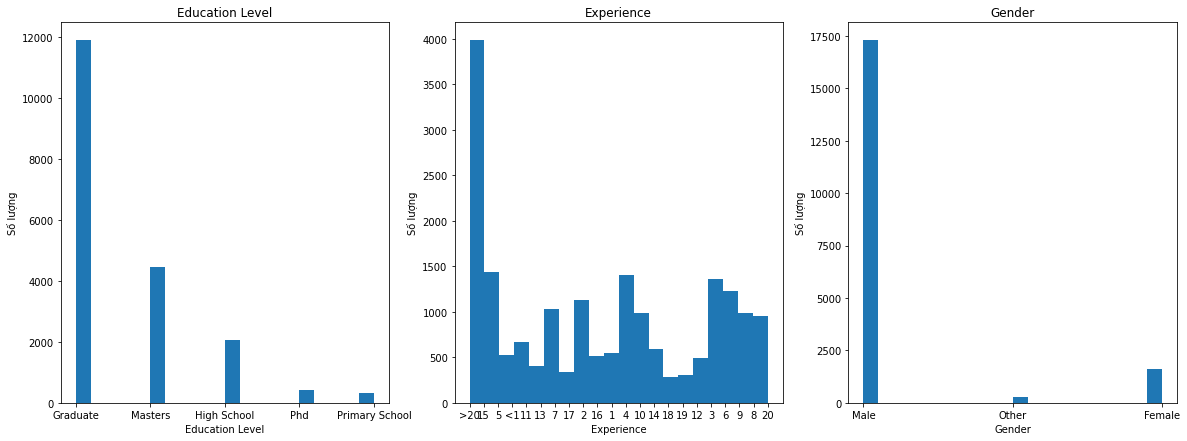

In [16]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title("Education Level")
plt.xlabel("Education Level")
plt.ylabel("Số lượng")
plt.hist( df[['education_level_random']], bins=20)

plt.subplot(1,3,2)
plt.title("Experience")
plt.xlabel("Experience")
plt.ylabel("Số lượng")
plt.hist( df[['experience_random']], bins=20)

plt.subplot(1,3,3)
plt.title("Gender")
plt.xlabel("Gender")
plt.ylabel("Số lượng")
plt.hist( df[['gender_random']], bins=20)
plt.show

In [36]:
df['gender_random'] = df['gender_random'].replace({'Male' : 1 , 'Female' : 0, 'Other' : 3})
df['education_level_random'] = df['education_level_random'].replace({'Primary School' : 0 , 'High School' : 1 , 'Graduate' : 2, 'Masters' : 3, 'Phd' : 4 })
df['experience_random'] = df['experience_random'].replace({'>20' : 21 , '<1' : 0 })
# X1 = pd.read_csv('C:/Users/acer/Downloads/input.csv')
#    print(X1.head())
#    X = X1[['Labeling']]
#    print(X.head())

<AxesSubplot:title={'center':'Education Level'}>

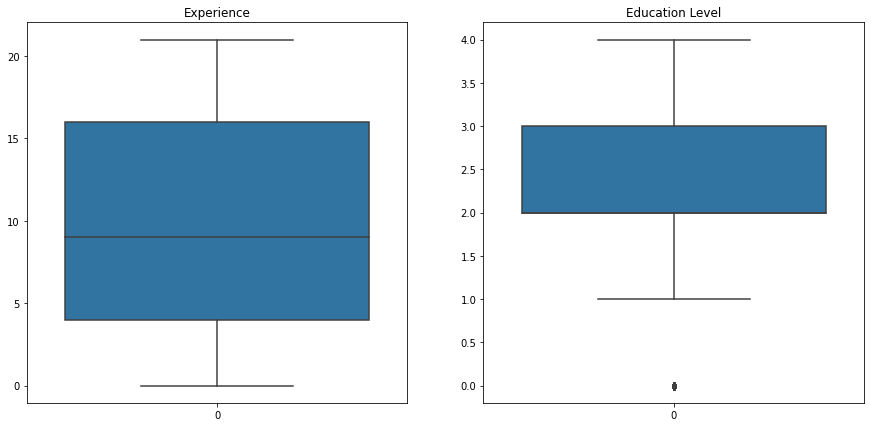

In [18]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Experience")
sb.boxplot(data =df['experience_random'])
plt.subplot(1,2,2)
plt.title("Education Level")
sb.boxplot(data =df['education_level_random'])

### Các đặc trưng có khá ít ngoại lệ

# Chuẩn hóa và Xử lý ngoại lệ
- Chuẩn hóa bằng Roust Scaler
- Xử lý ngoại lệ 

In [19]:
# Phân bố lệch
def skewed_distribution(df,feature):
    IQR=np.quantile(df[feature],0.75)-np.quantile(df[feature],0.25)
    lower_bridge_fare=df[feature].quantile(0.25)-(IQR*3)
    upper_bridge_fare=df[feature].quantile(0.75)+(IQR*3)

    skewed_distribution_data=df.copy()
    skewed_distribution_data.loc[skewed_distribution_data[feature]>=round(upper_bridge_fare,2),feature]=round(upper_bridge_fare,2)
    skewed_distribution_data.loc[skewed_distribution_data[feature]<=round(lower_bridge_fare,2),feature]=round(lower_bridge_fare,2)
    
    return skewed_distribution_data

In [20]:
# Chuẩn hóa Robust Scaler
data = df[['gender_random','education_level_random','experience_random','target']]
scaler=RobustScaler()
df_robust_scaler=pd.DataFrame(scaler.fit_transform(data),columns=data.columns)

# xử lý ngoại lệ 
# Biến gender
data_gender = skewed_distribution(df_robust_scaler,'gender_random')

# Biến Education level
data_education = skewed_distribution(data_gender,'education_level_random')

# Biến experience 
data_experience = skewed_distribution(data_education,'experience_random')
# data.head()


# Hàm đánh giá độ chính xác

In [21]:
def Logistic_Regression(df,feature1,feature2,feature3):
    data = df.copy()
    classifier= LogisticRegression(solver='lbfgs', random_state=1)
    X_train,X_test,y_train,y_test=train_test_split(data[[feature1,feature2,feature3]].fillna(0),df['target'],test_size=0.3, random_state=0)
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    return accuracy_score(y_test,y_pred)*100

  

In [22]:
# Độ chính xác sau khi sử dụng phương pháp hội quy Logistic và train_test_split
acc_logit = Logistic_Regression(data_experience ,'gender_random','education_level_random','experience_random')
print('Độ chính xác sau khi sử dụng hội quy Logistic:    ',acc_logit)


Độ chính xác sau khi sử dụng hội quy Logistic:     74.75643702157272


In [23]:
# Độ chính xác sau khi sử dụng cross_val_score
# hội quy Logistic
logit = LogisticRegression(solver='lbfgs', random_state=1)
accuracy  = cross_val_score(logit,df[['gender_random','education_level_random','experience_random']].fillna(0),df['target'], scoring = 'accuracy', cv = 5).mean()
print('Độ chính xác sau khi sử dụng cross_val_score:    ',accuracy)



Độ chính xác sau khi sử dụng cross_val_score:     0.7506524757649522


### Độ chính xác chỉ tăng khoảng 1% 

# Lựa chọn tham số


In [24]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['linear', 'rbf'], 'C':[1, 10]}
svc = svm.SVC()
X_train, X_test, y_train, y_test = train_test_split(df[['gender_random','education_level_random','experience_random']],df['target'], test_size=0.30)
grid_GBC = GridSearchCV(estimator=svc, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBC.fit(X_train, y_train)
print(" Results from Grid Search " )
print(" The best estimator : ",grid_GBC.best_estimator_)
print(" The best score :",grid_GBC.best_score_)
print(" The best parameters across: ",grid_GBC.best_params_)

 Results from Grid Search 
 The best estimator :  SVC(C=1, kernel='linear')
 The best score : 0.751006711409396
 The best parameters across:  {'C': 1, 'kernel': 'linear'}
